# Hello, MNIST!

Let's extend [Hello, World!](hello-world.ipynb) to an actual learning problem: MNIST! First, we download the data.

In [1]:
from data.mnist import load_mnist

# Load the MNIST dataset
train_images, train_labels, test_images, test_labels = load_mnist()

# Print shapes to verify loading
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


Next, let's plot a few training points.

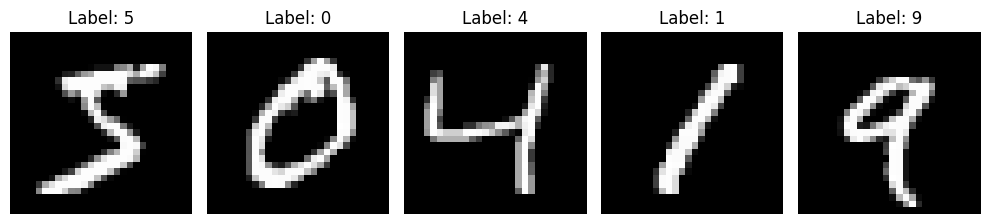

In [2]:
import matplotlib.pyplot as plt

# Create a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

# Plot each image and its label
for i in range(5):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].set_title(f'Label: {train_labels[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Now we flatten the inputs into vectors, encode the targets as one-hot vectors, and write a mini-batch sampler.

In [17]:
import jax
import jax.numpy as jnp

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

# Reshape images and convert labels
X_train = train_images.reshape(train_images.shape[0], -1)
y_train = one_hot(train_labels, 10)

# Get a batch
def get_batch(key, batch_size):
    idx = jax.random.choice(key, X_train.shape[1], shape=(batch_size,))
    return X_train[idx, :], y_train[idx, :]

Now we're ready to build our MLP.

In [18]:
from modula.atom import Linear
from modula.bond import ReLU

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
width = 256

mlp = Linear(output_dim, width)
mlp @= ReLU() @ Linear(width, width) 
mlp @= ReLU() @ Linear(width, input_dim)

print(mlp)

mlp.jit()

CompositeModule
...consists of 3 atoms and 2 bonds
...non-smooth
...input sensitivity is 1
...contributes proportion 3 to feature learning of any supermodule


Let's train the MLP for 1000 steps.

In [19]:
from tqdm.notebook import tqdm

def mse(w, inputs, targets):
    outputs = mlp(inputs, w)
    loss = ((outputs-targets) ** 2).mean()
    return loss

mse_and_grad = jax.jit(jax.value_and_grad(mse))

batch_size = 128
steps = 1000
learning_rate = 0.1

key = jax.random.PRNGKey(0)
w = mlp.initialize(key)
    
progress_bar = tqdm(range(steps), desc=f"Loss: {0:.4f}")
for step in progress_bar:
    key = jax.random.PRNGKey(step)
    inputs, targets = get_batch(key, batch_size)
    
    loss, grad_w = mse_and_grad(w, inputs, targets)
    d_w = mlp.dualize(grad_w)
    w = [weight - learning_rate * d_weight for weight, d_weight in zip(w, d_w)]
    progress_bar.set_description(f"Loss: {loss:.4f}")

Loss: 0.0000:   0%|          | 0/1000 [00:00<?, ?it/s]

And finally let's plot some test predictions.

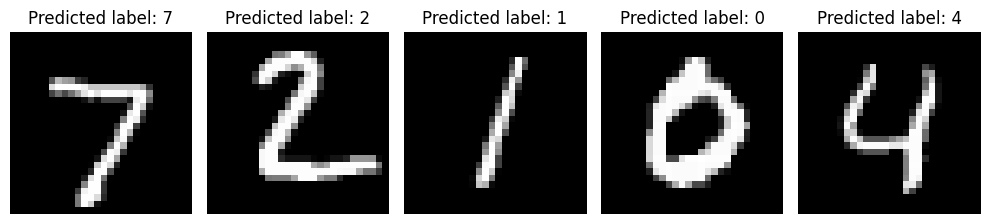

Accuracy on shown samples: 5/5
Overall test accuracy: 90.58%


In [23]:
# Get predictions for test images
X_test = test_images.reshape(test_images.shape[0], -1)
test_outputs = mlp(X_test, w)
predicted_labels = jnp.argmax(test_outputs, axis=1)

# Create a figure with subplots for multiple test images
n_samples = 5  # Number of test images to display
fig, axes = plt.subplots(1, n_samples, figsize=(10, 3))

# Plot each test image with predicted labels
for i in range(n_samples):
    axes[i].imshow(test_images[i], cmap='gray')
    axes[i].set_title(f'Predicted label: {int(predicted_labels[i])}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print accuracy for these samples
correct = (predicted_labels[:n_samples] == test_labels[:n_samples]).sum()
print(f"Accuracy on shown samples: {correct}/{n_samples}")

# Calculate and print overall test accuracy
total_correct = (predicted_labels == test_labels).sum()
total_samples = len(test_labels)
print(f"Overall test accuracy: {100 * total_correct/total_samples:.2f}%")